# Necessary Packages #

In [31]:
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import timeit
from PIL import Image, ImageOps
import cv2
from itertools import permutations
from skimage import io, color
from scipy.spatial import ConvexHull
import csv
import random
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Functions and Classes #

In [32]:
class Node:
    generatedEquallySpacedNodes = []
    def __init__(self, coordinates, isTraversable = True, isEquallySpaced = True):
        self.coordinates = coordinates
        self.isTraversable = isTraversable
        self.isEquallySpaced = isEquallySpaced
        self.neighbours = {}


    def addNeighbour(self, neighbour, cost):
        if neighbour.isTraversable:
            self.neighbours[neighbour] = cost
            return True
        else:
            return False
        

    def deleteNeighbour(self, neighbour):
        try:
            self.neighbours.pop(neighbour)
            return True
        except:
            return False
        
    def addUserDefinedNeighbour(self, possibleNeighbourNodes, maximumAllowableNeighbouringCost):
        for possibleNeighbour in possibleNeighbourNodes:
            cost = ((possibleNeighbour.getCoordinates()[0]-self.coordinates[0])**2+(possibleNeighbour.getCoordinates()[1]-self.coordinates[1])**2)**0.5
            if cost <= maximumAllowableNeighbouringCost:
                self.addNeighbour(possibleNeighbour, cost)
                possibleNeighbour.addNeighbour(self, cost)
                
    def getCoordinates(self):
        return self.coordinates
    


def fromImageToBooleanGrid(processedImage, spacing, ObstacleThreshold = 10):
    [imageWidth, imageHeight] = processedImage.size
    rows = math.floor(imageHeight / spacing)
    columns = math.floor(imageWidth / spacing)
    equallySpacedNodesMatrix = np.ones((rows, columns))
    rowCount = 0
    columnCount = 0
    for row in equallySpacedNodesMatrix:
        for node in row:
            if processedImage.getpixel((columnCount * spacing, rowCount * spacing)) < ObstacleThreshold:
                equallySpacedNodesMatrix[rowCount, columnCount] = 0
            columnCount += 1
        rowCount += 1
        columnCount = 0
    return equallySpacedNodesMatrix


def generateNodesFromMatrix(equallySpacedNodesMatrix, spacing):
    rows = equallySpacedNodesMatrix.shape[0]
    columns = equallySpacedNodesMatrix.shape[1]
    rowCount = 0
    columnCount = 0
    nodes = np.empty((rows, columns), dtype = object)
    for row in equallySpacedNodesMatrix:
        for element in row:
            if element == 1:
                node = Node(np.array((columnCount * spacing, rowCount * spacing)), True, True)
            else:
                node = Node((columnCount * spacing, rowCount * spacing), False, True)
            nodes[rowCount][columnCount] = node
            columnCount += 1
        rowCount += 1
        columnCount = 0

    return nodes






def getNodesCoordinatesFromNodesVector(nodesVetor):
    XTraversable = []
    YTraversable = []
    XObstacle = []
    YObstacle = []

    for node in nodesVetor:
        try:
            if node.isTraversable:
                XTraversable.append(node.getCoordinates()[0])
                YTraversable.append(node.getCoordinates()[1])
            else:
                XObstacle.append(node.getCoordinates()[0])
                YObstacle.append(node.getCoordinates()[1])
        except:
            pass
    return [[XTraversable, YTraversable], [XObstacle, YObstacle]]






def defineNeighbourhoodRelationsOfNodesMatrix(nodesMatrix, spacing):
    rowCount = 0
    columnCount = 0
    inputSpacing = spacing
    for row in nodesMatrix:
        for node in row:
            spacing = inputSpacing
            try:
                if not node.isTraversable:
                    spacing = float('inf')                          
                try:
                    node.addNeighbour(nodesMatrix[abs(rowCount-1)][abs(columnCount-1)], 2**0.5*spacing)
                except:

                    pass

                try:
                    node.addNeighbour(nodesMatrix[abs(rowCount - 1)][columnCount], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[abs(rowCount-1)][columnCount+1], 2**0.5*spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount][abs(columnCount-1)], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount][columnCount+1], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount+1][abs(columnCount-1)], 2**0.5*spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount+1][columnCount], spacing)
                except:
                    pass
                try:
                    node.addNeighbour(nodesMatrix[rowCount+1][columnCount+1], 2**0.5*spacing)
                except:
                    pass

            except:
                pass
            columnCount += 1

        rowCount += 1
        columnCount = 0
    return nodesMatrix





def getTraversableAndObstacleNodes(allNodesVector):
    traversableNodes = []
    obstacleNodes = []
    for node in allNodesVector:
        if node.isTraversable:
            traversableNodes.append(node)
        else:
            obstacleNodes.append(node)
        
    return [traversableNodes, obstacleNodes]






def generateUserDefinedNodes(greyImage, ObstacleThreshold,  nodesCoordinates, maximumAllowableNeighbouringCost, allNodesVector):
    
    generatedUserDefinedNodes = []
    for nodeCoordinate in nodesCoordinates:
        if greyImage.getpixel(nodeCoordinate) < ObstacleThreshold:
            isTraversable = False
        else:
            isTraversable = True
        tempNode = Node(nodeCoordinate, isTraversable, False)
        if tempNode not in allNodesVector[0] and tempNode not in allNodesVector[1]:
            if isTraversable:
                tempNode.addUserDefinedNeighbour(allNodesVector[0], maximumAllowableNeighbouringCost)
                allNodesVector[0].append(tempNode)
            else:
                tempNode.addUserDefinedNeighbour(allNodesVector[1], maximumAllowableNeighbouringCost)
                allNodesVector[1].append(tempNode)
        generatedUserDefinedNodes.append(tempNode)
    return generatedUserDefinedNodes
    
def getNodesCoordinatesTuplesFromNodesVector(nodesVetor):
    coordinates = []
    for node in nodesVetor:
        coordinates.append(node.coordinates.tolist())
    return coordinates


def calculateHeuristics(node, goalNode):
    return  ((node.coordinates[0] - goalNode.coordinates[0]) ** 2 + (node.coordinates[1] - goalNode.coordinates[1]) ** 2) ** 0.5




def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points

def isLineObstacleFree(start, end, grayImage):
    line_points = bresenham_line(start.coordinates[0], start.coordinates[1], end.coordinates[0], end.coordinates[1])
    for x, y in line_points:
        if grayImage[y, x] <= 240:  
            return False
    return True

def postPrunePath(path, grayImage):
    
    startingNode = path[0]
    endNode = path[-1]
    prunedPath = [path[0]] 

    i = 0
    while i < len(path) - 1:

        j = len(path) - 1
        while j > i:

            if isLineObstacleFree(path[i], path[j], grayImage):
                prunedPath.append(path[j])
                i = j
                break
            j -= 1
            if i == j:
                i += 1
                break
    if prunedPath[0] != startingNode:
        prunedPath.insert(0, startingNode)
    if prunedPath[-1] != endNode:
        prunedPath.append(endNode)

    return prunedPath




def AStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, isPostPruned = True, spacing = 40):
    '''previouslyFoundPathAndCost = generatedPaths.get((startingNode, goalNode), None)
    if previouslyFoundPathAndCost!= None and previouslyFoundPathAndCost[0][-1] != goalNode:
        previouslyFoundPathAndCost = None   
    if previouslyFoundPathAndCost != None:
        #print("Previously Generated Path Is Found!")
        return previouslyFoundPathAndCost'''
    
    openSet = [startingNode]
    closedSet = []
    g = {}
    parents = {}
    g[startingNode] = 0 
    parents[startingNode] = startingNode 
    subPath = None
    while len(openSet) > 0:
        n = None
        for temp in openSet:
            if n == None or g[temp] + calculateHeuristics(temp, goalNode) < g[n] + calculateHeuristics(n, goalNode):
                n = temp
                #should put a break in here to enhance the performance
        if n == goalNode or len(n.neighbours) == 0 :
            pass
        else:
            for (m, cost) in n.neighbours.items():
                if m not in openSet and m not in closedSet:
                    openSet.append(m)
                    parents[m] = n
                    g[m] = g[n] + cost
                else:
                    if g[m] > g[n] + cost:
                        g[m] = g[n] + cost
                        parents[m] = n
                        if m in closedSet:
                            closedSet.remove(m)
                            openSet.append(m)
        if n == None:
            print('>>>>Path does not exist!<<<<\n')
            return None
        
        if subPath != None:
            n = subPath[0][0]
            parents[goalNode] = n
            g[goalNode] = g[n] + subPath[1]

            n = goalNode

        if n == goalNode:
            path = []
            while parents[n] != n:
                path.append(n)
                n = parents[n]
            path.append(startingNode)
            totalCost = g[goalNode]
            pathCopy = path.copy()
            pathCopy.insert(0, goalNode)
            path.reverse()

            if isPostPruned:
                path = postPrunePath(path, cv2GrayImage)
                totalCost = calculatePathCost(path)
                pathCopy = path.copy()

            generatedPaths[(goalNode, startingNode)] = [pathCopy, totalCost]
            generatedPaths[(startingNode, goalNode)] = [path, totalCost]
            
            pathAndTotalCost = [path, totalCost]
            return pathAndTotalCost

        openSet.remove(n)
        closedSet.append(n)


        '''rho = ((goalNode.coordinates[0] - n.coordinates[0]) ** 2 + (goalNode.coordinates[1] - n.coordinates[1]) ** 2) ** 0.5
        if isLineObstacleFree(n, goalNode, cv2GrayImage):
            subPath = [[n, goalNode], rho]'''


    print('>>>>Path does not exist!<<<<\n')
    return None



def BiAStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, isPostPruned=True, spacing=40):
    '''previouslyFoundPathAndCost = generatedPaths.get((startingNode, goalNode), None)
    if previouslyFoundPathAndCost is not None and previouslyFoundPathAndCost[0][-1] != goalNode:
        previouslyFoundPathAndCost = None
    if previouslyFoundPathAndCost is not None:
        return previouslyFoundPathAndCost'''

    openSetForward = [startingNode]
    openSetBackward = [goalNode]
    closedSetForward = []
    closedSetBackward = []

    gForward = {startingNode: 0}
    gBackward = {goalNode: 0}
    parentsForward = {startingNode: startingNode}
    parentsBackward = {goalNode: goalNode}

    def reconstructPath(meetingNode):
        pathForward = []
        n = meetingNode
        while parentsForward[n] != n:
            pathForward.append(n)
            n = parentsForward[n]
        pathForward.append(startingNode)
        pathForward.reverse()

        pathBackward = []
        n = meetingNode
        while parentsBackward[n] != n:
            pathBackward.append(n)
            n = parentsBackward[n]

        path = pathForward + pathBackward[1:]
        totalCost = gForward[meetingNode] + gBackward[meetingNode]

        if isPostPruned:
            path = postPrunePath(path, cv2GrayImage)
            totalCost = calculatePathCost(path)

        generatedPaths[(startingNode, goalNode)] = [path, totalCost]
        generatedPaths[(goalNode, startingNode)] = [path[::-1], totalCost]
        return [path, totalCost]

    while len(openSetForward) > 0 and len(openSetBackward) > 0:
        nForward = min(openSetForward, key=lambda x: gForward[x] + calculateHeuristics(x, goalNode))
        openSetForward.remove(nForward)
        closedSetForward.append(nForward)

        for (m, cost) in nForward.neighbours.items():
            if m not in openSetForward and m not in closedSetForward:
                openSetForward.append(m)
                parentsForward[m] = nForward
                gForward[m] = gForward[nForward] + cost
            elif gForward.get(m, float('inf')) > gForward[nForward] + cost:
                gForward[m] = gForward[nForward] + cost
                parentsForward[m] = nForward

        if nForward in closedSetBackward:
            return reconstructPath(nForward)

        nBackward = min(openSetBackward, key=lambda x: gBackward[x] + calculateHeuristics(x, startingNode))
        openSetBackward.remove(nBackward)
        closedSetBackward.append(nBackward)

        for (m, cost) in nBackward.neighbours.items():
            if m not in openSetBackward and m not in closedSetBackward:
                openSetBackward.append(m)
                parentsBackward[m] = nBackward
                gBackward[m] = gBackward[nBackward] + cost
            elif gBackward.get(m, float('inf')) > gBackward[nBackward] + cost:
                gBackward[m] = gBackward[nBackward] + cost
                parentsBackward[m] = nBackward

        if nBackward in closedSetForward:
            return reconstructPath(nBackward)

    print('>>>>Path does not exist!<<<<\n')
    return None







class treeNode():
    def __init__(self, locationX, locationY):
        self.locationX = locationX
        self.locationY = locationY
        self.children = []
        self.parent = None
        self.cost = 0
        
class RRTAlgorithm():
    def __init__(self, start, goal, numIterations, grid, stepSize):
        self.randomTree = treeNode(start[0], start[1])
        self.goal = treeNode(goal[0], goal[1])
        self.nearestNode = None
        self.iterations = min(numIterations, 100000)
        self.grid = grid
        self.rho = stepSize
        self.path_distance = 0
        self.nearestDist = 10000
        self.numWayPoints = 0
        self.wayPoints = []

    def addChild(self, locationX, locationY):
        if(locationX == self.goal.locationX):
            self.nearestNode.children.append(self.goal)
            self.goal.parent = self.nearestNode
        else:
            tempNode = treeNode(locationX, locationY)
            self.nearestNode.children.append(tempNode)
            tempNode.parent = self.nearestNode

    def sampleAPoint(self):
        x = random.randint(1, self.grid.shape[1])
        y = random.randint(1, self.grid.shape[0])
        point = np.array([x,y])
        return point

    def steerToPoint(self, locationStart, locationEnd):
        offset = self.rho*self.unitVector(locationStart, locationEnd)
        point = np.array([locationStart.locationX+offset[0], locationStart.locationY+offset[1]])
        if point[0] >= self.grid.shape[1]:
            point[0] = self.grid.shape[1] - 1
        if point[1] >= self.grid.shape[0]:
            point[1] = self.grid.shape[0] - 1
        return point
    def isInObstacle(self, locationStart, locationEnd):
        u_hat = self.unitVector(locationStart, locationEnd)
        testPoint = np.array([0.0, 0.0])
        for i in range(self.rho):
            testPoint[0] = locationStart.locationX + i*u_hat[0]
            testPoint[1] = locationStart.locationY + i*u_hat[1]

            try:
                if self.grid[round(testPoint[1]), round(testPoint[0])] == 1:
                    return True
            except:
                return False
        return False
    def unitVector(self, locationStart, locationEnd):
        v = np.array([locationEnd[0] - locationStart.locationX, locationEnd[1]-locationStart.locationY])
        u_hat = v/np.linalg.norm(v)
        return u_hat
    def findNearest(self, root, point):
        if not root:
            return
        dist = self.distance(root, point)
        if dist <= self.nearestDist:
            self.nearestNode = root
            self.nearestDist = dist

        for child in root.children:
            self.findNearest(child, point)
        pass

    def distance(self, node1, point):
        dist = np.sqrt((node1.locationX-point[0])**2+(node1.locationY-point[1])**2)
        return dist

    def goalFound(self, point):
        if self.distance(self.goal, point)<=self.rho:
            return True
        pass

    def resetNearestValues(self):
        self.nearestNode = None
        self.nearestDist = 10000

    def retraceRRTPath(self, goal):
        
        if goal.locationX == self.randomTree.locationX:
            return
        self.numWayPoints+=1
        currentPoint = np.array([goal.locationX, goal.locationY])
        self.wayPoints.insert(0, currentPoint)
        self.path_distance+=self.rho
        self.retraceRRTPath(goal.parent)


class RRTStarAlgorithm(RRTAlgorithm):
    def __init__(self, start, goal, numIterations, grid, stepSize, searchRadius):
        super().__init__(start, goal, numIterations, grid, stepSize)
        self.searchRadius = searchRadius

    def findNeighbours(self, point):
        neighbours = []
        def recursiveSearch(node):
            if not node:
                return
            dist = self.distance(node, point)
            if dist <= self.searchRadius:
                neighbours.append(node)
            for child in node.children:
                recursiveSearch(child)
        recursiveSearch(self.randomTree)
        return neighbours

    def rewire(self, newNode, neighbours):
        for neighbour in neighbours:
            potentialCost = newNode.cost + self.distance(newNode, np.array([neighbour.locationX, neighbour.locationY]))
            if potentialCost < neighbour.cost:
                if not self.isInObstacle(newNode, np.array([neighbour.locationX, neighbour.locationY])):
                    neighbour.parent.children.remove(neighbour)
                    neighbour.parent = newNode
                    neighbour.cost = potentialCost
                    newNode.children.append(neighbour)

    def addChild(self, locationX, locationY):
        tempNode = treeNode(locationX, locationY)
        tempNode.parent = self.nearestNode
        tempNode.cost = self.nearestNode.cost + self.distance(self.nearestNode, [locationX, locationY])
        self.nearestNode.children.append(tempNode)
        return tempNode


def RRTStarAlgo(startingNode, goalNode, imageDirectory, numberOfIterations, stepSize, searchRadius):
    img = Image.open(imageDirectory)
    img = ImageOps.grayscale(img)
    np_img = np.array(img)
    np_img = ~np_img
    np_img[np_img > 0] = 1

    np.save('RRTImage.npy', np_img)
    grid = np.load('RRTImage.npy')
    start = np.array([startingNode[0], startingNode[1]])
    goal = np.array([goalNode[0], goalNode[1]])

    '''goalRegion = plt.Circle((goal[0], goal[1]), stepSize, color='b', fill=False)
    fig = plt.figure("RRT* Algorithm")
    plt.imshow(grid, cmap='binary')
    plt.plot(start[0], start[1], 'ro')
    plt.plot(goal[0], goal[1], 'bo')
    ax = fig.gca()
    ax.add_patch(goalRegion)
    plt.xlabel('X-axis $(m)$')
    plt.ylabel('Y-axis $(m)$')'''

    rrtStar = RRTStarAlgorithm(start, goal, numberOfIterations, grid, stepSize, searchRadius)

    for i in range(rrtStar.iterations):
        rrtStar.resetNearestValues()
        point = rrtStar.sampleAPoint()
        rrtStar.findNearest(rrtStar.randomTree, point)
        newPoint = rrtStar.steerToPoint(rrtStar.nearestNode, point)
        
        
        if not rrtStar.isInObstacle(rrtStar.nearestNode, newPoint):
            newNode = rrtStar.addChild(newPoint[0], newPoint[1])
            neighbours = rrtStar.findNeighbours(newPoint)
            rrtStar.rewire(newNode, neighbours)
            if rrtStar.goalFound(newPoint):
                rrtStar.addChild(goal[0], goal[1])
                rrtStar.goal.parent = newNode
                break

    rrtStar.retraceRRTPath(rrtStar.goal)
    rrtStar.wayPoints.insert(0, start)

    '''print("Number of wayPoints: ", rrtStar.numWayPoints)
    print("Path Distance (m): ", rrtStar.path_distance)
    print("Way Points: ", rrtStar.wayPoints)'''

    wayPoints = [tuple(arr) for arr in rrtStar.wayPoints]
    '''for i in range(len(rrtStar.wayPoints) - 1):
        plt.imshow(grid, cmap='binary')
        plt.plot([rrtStar.wayPoints[i][0], rrtStar.wayPoints[i + 1][0]], [rrtStar.wayPoints[i][1], rrtStar.wayPoints[i + 1][1]], 'ro', linestyle="--")
    plt.show()'''

    return [wayPoints, rrtStar.path_distance]



def calculatePathCost(path):
    cost = 0
    i = 0
    while i < len(path) - 1:
        distance = ((path[i + 1].coordinates[0] - path[i].coordinates[0])**2 + (path[i + 1].coordinates[1] - path[i].coordinates[1])**2)**0.5
        cost += distance
        i += 1
    
    return cost


def calculatePathCostFromCoordinates(path):
    cost = 0
    i = 0
    while i < len(path) - 1:
        distance = ((path[i + 1][0] - path[i][0])**2 + (path[i + 1][1] - path[i][1])**2)**0.5
        cost += distance
        i += 1
    
    return cost


def getGoalNodesCentroidCoordinates(goalNodes):
    centroidX = 0
    centroidY = 0

    for node in goalNodes:
        try:
            centroidX += node.getCoordinates()[0]
            centroidY += node.getCoordinates()[1]
        except:
            pass
    centroidX /= len(goalNodes)
    centroidY /= len(goalNodes)
    return (int(centroidX), int(centroidY))



def getAngleAlpha(centroidNodeCoordinates, currentNodeCoordinates, goalNodeCoordinates):
    centroidCurrentVector = np.array([currentNodeCoordinates[0] - centroidNodeCoordinates[0], currentNodeCoordinates[1] - centroidNodeCoordinates[1]])

    xGoal, yGoal = goalNodeCoordinates
    centroidGoalVector = np.array([xGoal - centroidNodeCoordinates[0], yGoal - centroidNodeCoordinates[1]])

    angleRad = np.arccos(np.dot(centroidCurrentVector, centroidGoalVector)/(np.linalg.norm(centroidCurrentVector)*np.linalg.norm(centroidGoalVector)))
    betaD = np.degrees(angleRad)

    return betaD



def getAngleBeta(startingNodeCoordinates, currentNodeCoordinates, goalNodeCoordinates):

    startingCurrentVector = np.array([currentNodeCoordinates[0] - startingNodeCoordinates[0], currentNodeCoordinates[1] - startingNodeCoordinates[1]])

    xGoal, yGoal = goalNodeCoordinates
    startGoalVector = np.array([xGoal - startingNodeCoordinates[0], yGoal - startingNodeCoordinates[1]])

    angleRad = np.arccos(np.dot(startingCurrentVector, startGoalVector)/(np.linalg.norm(startingCurrentVector)*np.linalg.norm(startGoalVector)))
    gammaD = np.degrees(angleRad)

    return gammaD




def getAngleGamma(currentNodeCoordinates, nearGoalNodeCoordinates, temporaryGoalNodeCoordinates):

    xGoalNear, yGoalNear = nearGoalNodeCoordinates
    currentNearGoalVector = np.array([xGoalNear - currentNodeCoordinates[0], yGoalNear - currentNodeCoordinates[1]])
    xGoalTemp, yGoalTemp = temporaryGoalNodeCoordinates
    currentTempGoalVector = np.array([xGoalTemp - currentNodeCoordinates[0], yGoalTemp - currentNodeCoordinates[1]])

    angleRad = np.arccos(np.dot(currentNearGoalVector, currentTempGoalVector)/(np.linalg.norm(currentNearGoalVector)*np.linalg.norm(currentTempGoalVector)))
    zetaD = np.degrees(angleRad)

    return zetaD



def generateTotalPath(startingNode, orderedGoalNodes, generatedPaths, cv2GrayImage):

    totalPath = []
    costs = []
    totalCost = 0

    startingNodeHolder = startingNode
    for node in orderedGoalNodes[1:-1]:

        AstarAlgoOutput = AStarAlgorithm(startingNodeHolder, node, generatedPaths, cv2GrayImage)
        startingNodeHolder = node
        totalPath = totalPath + AstarAlgoOutput[0]
        costs.append(AstarAlgoOutput[1])
        totalCost = totalCost + AstarAlgoOutput[1]
    AstarAlgoOutput = AStarAlgorithm(startingNodeHolder, startingNode, generatedPaths, cv2GrayImage)
    totalPath = totalPath + AstarAlgoOutput[0]
    costs.append(AstarAlgoOutput[1])
    totalCost = totalCost + AstarAlgoOutput[1]

    totalPathAndCost = [totalPath, totalCost]
    return totalPathAndCost

def removeConsecutiveDuplicateNodes(path):

    result = []
    

    for i in range(len(path)):

        if i == len(path) - 1 or path[i].coordinates != path[i + 1].coordinates:
            result.append(path[i])
    result.append(path[0])
    return result


def getCombinedAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage, closedPath = True):
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes.copy()
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        # Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        # A*-Based Ordering
        if len(orderedGoalNodes)>=3:
            counter = 3
            while counter > 0:
                for node in orderedGoalNodes:
                    orderedGoalNodes[orderedGoalNodes.index(node)][1] = \
                    AStarAlgorithm(startingNodeHolder, node[0], generatedPaths, cv2GrayImage)[1]
                    counter -= 1
                    if counter == 0:
                        orderedOrderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
                        if orderedGoalNodes == orderedOrderedGoalNodes:
                            break
                        else:
                            orderedGoalNodes = orderedOrderedGoalNodes
                            counter = 1

        holder = orderedGoalNodes[0][0]

        if len(orderedGoalNodes) > 2:
            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            gamma1 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates, orderedGoalNodes[2][0].coordinates)
            gamma2 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates, orderedGoalNodes[2][0].coordinates)

            if alpha1 + gamma2 > alpha2 + gamma1 and alpha1 > alpha2:
                holder = orderedGoalNodes[1][0]

        elif len(orderedGoalNodes) < 3 and closedPath:
            costToAbsoluteStartingNode = AStarAlgorithm(startingNodeHolder, absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
            orderedGoalNodes.append([absoluteStartingNode, costToAbsoluteStartingNode])

            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            gamma1 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates, orderedGoalNodes[2][0].coordinates)
            gamma2 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates, orderedGoalNodes[2][0].coordinates)

            if alpha1 + gamma2 > alpha2 + gamma1 and alpha1 > alpha2:
                holder = orderedGoalNodes[1][0]
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
            else:
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])

            goalNodesHolder.remove(orderedGoalNodes[0][0])
            goalNodesHolder.remove(orderedGoalNodes[1][0])
            if closedPath:
                orderedGoalNodesOutput.insert(0, absoluteStartingNode)
                orderedGoalNodesOutput.append(absoluteStartingNode)
            return orderedGoalNodesOutput

        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)

    if closedPath:
        orderedGoalNodesOutput.append(absoluteStartingNode)
    return orderedGoalNodesOutput




def getSequentialAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage, closedPath = True):
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes.copy()
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        # Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        # A*-Based Ordering
        if len(orderedGoalNodes)>=3:
            counter = 3
            while counter > 0:
                for node in orderedGoalNodes:
                    orderedGoalNodes[orderedGoalNodes.index(node)][1] = \
                    AStarAlgorithm(startingNodeHolder, node[0], generatedPaths, cv2GrayImage)[1]
                    counter -= 1
                    if counter == 0:
                        orderedOrderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
                        if orderedGoalNodes == orderedOrderedGoalNodes:
                            break
                        else:
                            orderedGoalNodes = orderedOrderedGoalNodes
                            counter = 1

        holder = orderedGoalNodes[0][0]

        if len(orderedGoalNodes) > 2:
            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            beta1 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            beta2 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            gamma1 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates, orderedGoalNodes[2][0].coordinates)
            gamma2 = getAngleGamma(startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates, orderedGoalNodes[2][0].coordinates)

            if alpha1 > alpha2 and gamma1 < gamma2 and beta1 > beta2:
                holder = orderedGoalNodes[1][0]

        elif len(orderedGoalNodes) < 3 and closedPath:
            costToAbsoluteStartingNode = AStarAlgorithm(startingNodeHolder, absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
            orderedGoalNodes.append([absoluteStartingNode, costToAbsoluteStartingNode])

            alpha1 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            alpha2 = getAngleAlpha(centroidNodeCoordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            beta1 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[0][0].coordinates)
            beta2 = getAngleBeta(absoluteStartingNode.coordinates, startingNodeHolder.coordinates, orderedGoalNodes[1][0].coordinates)

            if alpha1 > alpha2 and beta1 > beta2: #and zeta1 < zeta2:
                holder = orderedGoalNodes[1][0]
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
            else:
                orderedGoalNodesOutput.append(orderedGoalNodes[0][0])
                orderedGoalNodesOutput.append(orderedGoalNodes[1][0])
            if closedPath:
                orderedGoalNodesOutput.insert(0, absoluteStartingNode)
                orderedGoalNodesOutput.append(absoluteStartingNode)
            return orderedGoalNodesOutput

        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)

    if closedPath:
        orderedGoalNodesOutput.append(absoluteStartingNode)
    return orderedGoalNodesOutput

    
def getAngleBasedEnsembleOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage, closedPath = True):

    combinedAngleBasedOrderedGoalNodesStartTime = time.time()
    combinedAngleBasedOrderedGoalNodes = getCombinedAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostCombined = generateTotalPath(absoluteStartingNode, combinedAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    combinedAngleBasedOrderedGoalNodesEndTime = time.time()
    combinedAngleBasedOrderedGoalNodesExecutionTime = combinedAngleBasedOrderedGoalNodesEndTime - combinedAngleBasedOrderedGoalNodesStartTime


    


    sequentialAngleBasedOrderedGoalNodesStartTime = time.time()
    sequentialAngleBasedOrderedGoalNodes = getSequentialAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostSequential = generateTotalPath(absoluteStartingNode, sequentialAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    sequentialAngleBasedOrderedGoalNodesEndTime = time.time()
    sequentialAngleBasedOrderedGoalNodesExecutionTime = sequentialAngleBasedOrderedGoalNodesEndTime - sequentialAngleBasedOrderedGoalNodesStartTime   




    outputs = [(combinedAngleBasedOrderedGoalNodes, totalPathAndCostCombined[0], totalPathAndCostCombined[1], combinedAngleBasedOrderedGoalNodesExecutionTime, 'Combined'),
                (sequentialAngleBasedOrderedGoalNodes, totalPathAndCostSequential[0], totalPathAndCostSequential[1], sequentialAngleBasedOrderedGoalNodesExecutionTime, 'Sequential')]
    
    orderedOutputs = sorted(outputs, key = lambda x: x[2])
    return orderedOutputs

def getNearestOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, cv2GrayImage, closedPath = True): #This function resort the goalNodes list so that the optimal order to visit the goal nodes is obtained
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        #Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
            orderedGoalNodes.append([node, AStarAlgorithm(startingNodeHolder, node, generatedPaths, cv2GrayImage)[1]])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        
        holder = orderedGoalNodes[0][0]
        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)
    if closedPath:
        orderedGoalNodesOutput.insert(0, absoluteStartingNode)
        orderedGoalNodesOutput.append(absoluteStartingNode)
    return orderedGoalNodesOutput


def getMuGONAOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, cv2GrayImage, closedPath = True, nonZiczac = True): 
    startingNodeHolder = absoluteStartingNode
    goalNodesHolder = goalNodes
    orderedGoalNodesOutput = []

    while len(goalNodesHolder)>0:
        orderedGoalNodes = []
        #Euclidean-Based Heuristic Ordering
        for node in goalNodesHolder:
            orderedGoalNodes.append([node, math.sqrt((startingNodeHolder.coordinates[0] - node.coordinates[0]) ** 2 + (startingNodeHolder.coordinates[1] - node.coordinates[1]) ** 2)])
        orderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
        #A*-Based Ordering
        if len(orderedGoalNodes)>=3:
            counter = 3
            while counter > 0:
                for node in orderedGoalNodes:
                    orderedGoalNodes[orderedGoalNodes.index(node)][1] = \
                    AStarAlgorithm(startingNodeHolder, node[0], generatedPaths, cv2GrayImage)[1]
                    counter -= 1
                    if counter == 0:
                        orderedOrderedGoalNodes = sorted(orderedGoalNodes, key=lambda x: x[1])
                        if orderedGoalNodes == orderedOrderedGoalNodes:
                            break

                        else:
                            orderedGoalNodes = orderedOrderedGoalNodes
                            counter = 1# I have to check if putting 1 instead of 3 does not affect the algorithm badly

        holder = orderedGoalNodes[0][0]
        if len(orderedGoalNodes) < 3 and closedPath:
            costToAbsoluteStartingNode = AStarAlgorithm(node, absoluteStartingNode, generatedPaths, cv2GrayImage)
            orderedGoalNodes.append([absoluteStartingNode, costToAbsoluteStartingNode])

        if not nonZiczac:
            if len(orderedGoalNodes) > 1 and startingNodeHolder != absoluteStartingNode:  # for ziczac paths
                costToAbsoluteStartingNode1 = \
                AStarAlgorithm(orderedGoalNodes[0][0], absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
                costToAbsoluteStartingNode2 = \
                AStarAlgorithm(orderedGoalNodes[1][0], absoluteStartingNode, generatedPaths, cv2GrayImage)[1]
                if (costToAbsoluteStartingNode1 < costToAbsoluteStartingNode2):
                    holder = orderedGoalNodes[1][0]
        else:
            if len(orderedGoalNodes) > 2:
                costBetweenNode1AndTemporaryGoalNode = \
                    AStarAlgorithm(orderedGoalNodes[0][0], orderedGoalNodes[2][0], generatedPaths, cv2GrayImage)[1]
                costBetweenNode2AndTemporaryGoalNode = \
                    AStarAlgorithm(orderedGoalNodes[1][0], orderedGoalNodes[2][0], generatedPaths, cv2GrayImage)[1]
                costBetweenNode1AndNode2 = \
                    AStarAlgorithm(orderedGoalNodes[0][0], orderedGoalNodes[1][0], generatedPaths, cv2GrayImage)[1]
                if orderedGoalNodes[0][1] + costBetweenNode1AndNode2 + costBetweenNode2AndTemporaryGoalNode > \
                        orderedGoalNodes[1][1] + costBetweenNode1AndNode2 + costBetweenNode1AndTemporaryGoalNode:  #I figured out that the common term in both expression can be cancelled from both sides of the inequality
                    holder = orderedGoalNodes[1][0]

        orderedGoalNodesOutput.append(holder)
        startingNodeHolder = holder
        goalNodesHolder.remove(holder)
        #print(f"orderedGoalNodesOutput: {orderedGoalNodesOutput}\n")
    if closedPath:
        orderedGoalNodesOutput.append(absoluteStartingNode)
        orderedGoalNodesOutput.insert(0, absoluteStartingNode)
    #print("The MuGONA-Based ordering Process is FINISHED!!\n")
    return orderedGoalNodesOutput


def ensembleOrderedGoalNodes(absoluteStartingNode, goalNodes, generatedPaths, centroidNodeCoordinates, cv2GrayImage):

    MuGONAOrderedGoalNodesStartTime = time.time()
    MuGONAOrderedGoalNodes = getMuGONAOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
    totalPathAndCostMuGONA = generateTotalPath(absoluteStartingNode, MuGONAOrderedGoalNodes, generatedPaths, cv2GrayImage)
    MuGONAOrderedGoalNodesEndTime = time.time()
    MuGONAOrderedGoalNodesExecutionTime = MuGONAOrderedGoalNodesEndTime - MuGONAOrderedGoalNodesStartTime


    nearestNeighbourOrderedGoalNodesStartTime = time.time()
    nearestNeighbourOrderedGoalNodes = getNearestOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
    totalPathAndCostNearestNeighbour = generateTotalPath(absoluteStartingNode, nearestNeighbourOrderedGoalNodes, generatedPaths, cv2GrayImage)
    nearestNeighbourOrderedGoalNodesEndTime = time.time()
    nearestNeighbourOrderedGoalNodesExecutionTime = nearestNeighbourOrderedGoalNodesEndTime - nearestNeighbourOrderedGoalNodesStartTime


    combinedAngleBasedOrderedGoalNodesStartTime = time.time()
    combinedAngleBasedOrderedGoalNodes = getCombinedAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostCombined = generateTotalPath(absoluteStartingNode, combinedAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    combinedAngleBasedOrderedGoalNodesEndTime = time.time()
    combinedAngleBasedOrderedGoalNodesExecutionTime = combinedAngleBasedOrderedGoalNodesEndTime - combinedAngleBasedOrderedGoalNodesStartTime


    


    sequentialAngleBasedOrderedGoalNodesStartTime = time.time()
    sequentialAngleBasedOrderedGoalNodes = getSequentialAngleBasedOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, centroidNodeCoordinates, cv2GrayImage)
    totalPathAndCostSequential = generateTotalPath(absoluteStartingNode, sequentialAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
    sequentialAngleBasedOrderedGoalNodesEndTime = time.time()
    sequentialAngleBasedOrderedGoalNodesExecutionTime = sequentialAngleBasedOrderedGoalNodesEndTime - sequentialAngleBasedOrderedGoalNodesStartTime


    outputs = [(MuGONAOrderedGoalNodes, totalPathAndCostMuGONA[0], totalPathAndCostMuGONA[1], MuGONAOrderedGoalNodesExecutionTime, 'MuGONA'), (nearestNeighbourOrderedGoalNodes, totalPathAndCostNearestNeighbour[0], totalPathAndCostNearestNeighbour[1], nearestNeighbourOrderedGoalNodesExecutionTime, 'NN'), 
               (combinedAngleBasedOrderedGoalNodes, totalPathAndCostCombined[0], totalPathAndCostCombined[1], combinedAngleBasedOrderedGoalNodesExecutionTime, 'Combined'), (sequentialAngleBasedOrderedGoalNodes, totalPathAndCostSequential[0], totalPathAndCostSequential[1], sequentialAngleBasedOrderedGoalNodesExecutionTime, 'Sequential')]




    orderedOutputs = sorted(outputs, key = lambda x: x[2])
    
    return orderedOutputs


def getBestAStarBasedOrder(startingNode, goalNodes, generatedPaths, cv2GrayImage):
    cost = -1
    optimalPath = None
    possibleOrders = list(permutations(goalNodes))
    for possibleOrder in possibleOrders:
        possibleOrder = list(possibleOrder)
        possibleOrder.insert(0, startingNode)
        possibleOrder.append(startingNode)
        generatedPath = generateTotalPath(startingNode, possibleOrder, generatedPaths, cv2GrayImage)
        if cost < 0 or generatedPath[1] < cost:
            cost = generatedPath[1]
            optimalPath = generatedPath[0]
            optimalOrder = possibleOrder
    return [optimalPath, cost, optimalOrder]






def calculate_path_length(nodes):
    total_distance = 0
    for i in range(len(nodes) - 1):
        total_distance += np.linalg.norm(np.array(nodes[i].coordinates) - np.array(nodes[i + 1].coordinates))
    total_distance += np.linalg.norm(np.array(nodes[-1].coordinates) - np.array(nodes[0].coordinates))  # Close the loop
    return total_distance


def modifiedTwoOptPostPruning(nodes, cv2GrayImage):
    best_order = nodes[:]
    improved = True
    
    while improved:
        improved = False
        for i in range(1, len(best_order) - 2):
            for j in range(i + 1, len(best_order)):
                if j - i == 1 :  # Consecutive nodes, skip
                    continue
                if i>0 and j< len(best_order) -1: 
                    if not isLineObstacleFree(best_order[i-1], best_order[j], cv2GrayImage) or not isLineObstacleFree(best_order[i], best_order[j+1], cv2GrayImage):
                        continue
                new_order = best_order[:]
                new_order[i:j] = reversed(best_order[i:j])
                
                if calculate_path_length(new_order) < calculate_path_length(best_order):
                    best_order = new_order
                    improved = True
         
    return best_order




def two_opt_algorithm_with_Astar(startingNode, nodes, generatedPaths, cv2GrayImage):
    best_order = nodes[:]
    improved = True
    
    while improved:
        improved = False
        for i in range(1, len(best_order) - 2):
            for j in range(i + 1, len(best_order)):
                if j - i == 1:  # Consecutive nodes, skip
                    continue
                new_order = best_order[:]
                new_order[i:j] = reversed(best_order[i:j])
                
                if generateTotalPath(startingNode, new_order, generatedPaths, cv2GrayImage)[1] < generateTotalPath(startingNode, best_order, generatedPaths, cv2GrayImage)[1]:
                    best_order = new_order
                    improved = True
                    
    return best_order
    


def generateEuclideanTotalPath(startingNode, orderedGoalNodes, generatedPaths):
    totalPath = []
    costs = []
    totalCost = 0

    startingNodeHolder = startingNode
    for node in orderedGoalNodes:
        currentCost = ((node.coordinates[0]-startingNodeHolder.coordinates[0])**2+(node.coordinates[1]-startingNodeHolder.coordinates[1])**2)**0.5
        #currentCost = np.linalg.norm(node.coordinates-startingNodeHolder.coordinates)
        costs.append(currentCost)
        totalCost = totalCost + currentCost
        startingNodeHolder = node

    finalTotalPath = orderedGoalNodes
    finalTotalPath.insert(0, startingNode)

    
    totalPathAndCost = [finalTotalPath, totalCost]
    return totalPathAndCost



def getTSPSolverBasedOrder(startingNode, goalNodes, generatedPaths, cv2GrayImage):

    allNodes = [startingNode] + goalNodes 
    numNodes = len(allNodes)
    #print(f"The number of nodes is: {numNodes}")
    distance_matrix = [
        [
            math.floor(AStarAlgorithm(allNodes[i], allNodes[j], generatedPaths, cv2GrayImage, True)[1])
            for j in range(numNodes)
        ]
        for i in range(numNodes)
    ]

    

    manager = pywrapcp.RoutingIndexManager(numNodes, 1, 0)

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        #print(f"Distance callback: from_node={from_node}, to_node={to_node}, cost={distance_matrix[from_node][to_node]}")
        #print(distance_matrix[from_node][to_node])
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    solution = routing.SolveWithParameters(search_parameters)
    def print_solution(manager, routing, solution):
        """Prints solution on console."""
        print(f"Objective: {solution.ObjectiveValue()} miles")
        index = routing.Start(0)
        plan_output = "Route for vehicle 0:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        plan_output += f" {manager.IndexToNode(index)}\n"
        print(plan_output)
        plan_output += f"Route distance: {route_distance}miles\n"
    print_solution(manager, routing, solution)

    if solution:

        index = routing.Start(0)
        optimal_order = []
        while not routing.IsEnd(index):
            #print(f"Visiting node: {manager.IndexToNode(index)}")
            optimal_order.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))

        optimal_order_nodes = [allNodes[i] for i in optimal_order]
        
        optimalPath, actualCost = generateTotalPath(startingNode, optimal_order_nodes + [startingNode], generatedPaths, cv2GrayImage)

        return [optimalPath, actualCost, optimal_order_nodes]

    return [None, -1, None]

#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
###################################################   MAIN   ####################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################
#################################################################################################################

# Uploading The Map and Setting User Choices #

In [33]:
imageDirectory = 'map.png'
image = Image.open(imageDirectory)
greyImage = image.convert('L')
spacing =40#pixels 
scale = 1 #m/pixel
obstacleThreshold = 200 #less than 200 grey value--> obstacle

# Map Pre-Processing #

In [34]:
# Generating a boolean matrix that has the coordinates of the equally spaced nodes, If they are located on obstacels the value is 0 and 1 else where
equallySpacedNodesMatrix = fromImageToBooleanGrid(greyImage, spacing, obstacleThreshold)

# Transforming the boolean matrix of a matrix with Node() objects having their coordinates and traversability defined.
nodesMatrix = generateNodesFromMatrix(equallySpacedNodesMatrix, spacing)

# Obtaining the coordinates of both traversable and obstacle nodes in lists form to be plotted
nodesCoordinates = getNodesCoordinatesFromNodesVector(nodesMatrix.flatten())

XTraversable, YTraversable = nodesCoordinates[0][0], nodesCoordinates[0][1]
XObstacle, YObstacle = nodesCoordinates[1][0], nodesCoordinates[1][1]

defineNeighbourhoodRelationsOfNodesMatrix(nodesMatrix, spacing)

generatedPaths = {}
allNodesVector = getTraversableAndObstacleNodes(nodesMatrix.flatten())

userDefinedNodesCoordinates = [(300, 300), (400, 1255), (4314, 154), (646, 3678), (2100, 2325), (2710, 106), (1266, 164), (4000, 3660), (2800, 1775), (2475, 3277), (4200, 1500)]# list of goal nodes to visit
userDefinedNodesCoordinates = [nodesMatrix[0][0].coordinates]

maximumAllowableNeighbouringCost = (2*spacing**2)**0.5
userDefinedNodes = generateUserDefinedNodes(greyImage, obstacleThreshold, userDefinedNodesCoordinates, maximumAllowableNeighbouringCost, allNodesVector)

## `Equidistant Node Generation` ##

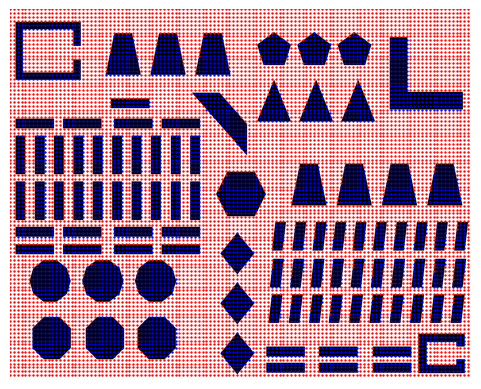

In [35]:
plt.scatter(XTraversable, YTraversable, c ='r', s=0.5)
plt.scatter(XObstacle, YObstacle, c ='b', s=0.5) 
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')
# plt.savefig('Equidistant Node Generation.png', dpi = 600, bbox_inches = 'tight')
plt.show()

### `Non-Navigable Nodes` ###

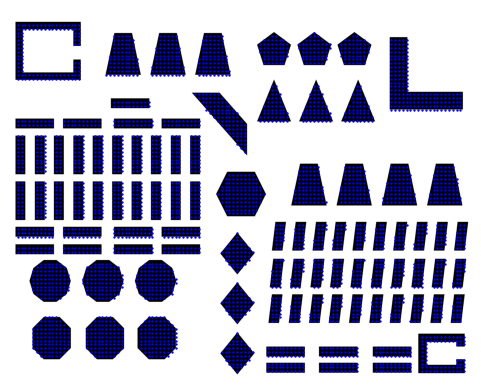

In [36]:
plt.scatter(XObstacle, YObstacle, c ='b', s=0.5) 
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')
# plt.savefig('Non-Navigable Nodes.png', dpi = 600, bbox_inches = 'tight')
plt.show()

### `Obstacle Contour Detection` ###

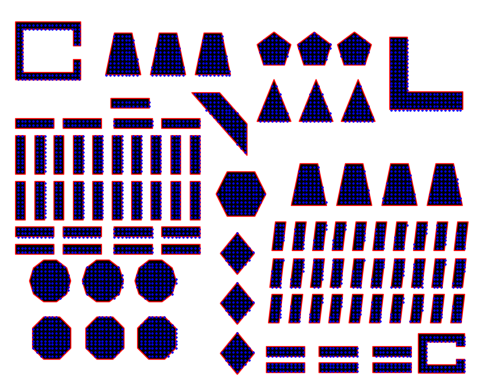

In [37]:
cv2GrayImage = cv2.imread(imageDirectory, cv2.IMREAD_GRAYSCALE)
obstacleThreshold = 128 
_, cv2BinaryImage = cv2.threshold(cv2GrayImage, obstacleThreshold, 255, cv2.THRESH_BINARY)
invertedGrayImage = cv2.bitwise_not(cv2GrayImage)
_, invertedBinaryImage = cv2.threshold(invertedGrayImage, 128, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(invertedBinaryImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

imageBGR = cv2.cvtColor(cv2GrayImage, cv2.COLOR_GRAY2BGR)

cv2.drawContours(imageBGR, contours, -1, (0, 0, 255), 10)  
plt.scatter(XObstacle, YObstacle, c ='b', s=0.5) 
plt.imshow(cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB))
plt.axis('off') 
# plt.savefig('Obstacle Contour Detection.png', dpi = 600, bbox_inches = 'tight')
plt.show()

### `Neighbourhood Graph: Equidistant Vs User-Defined` ###

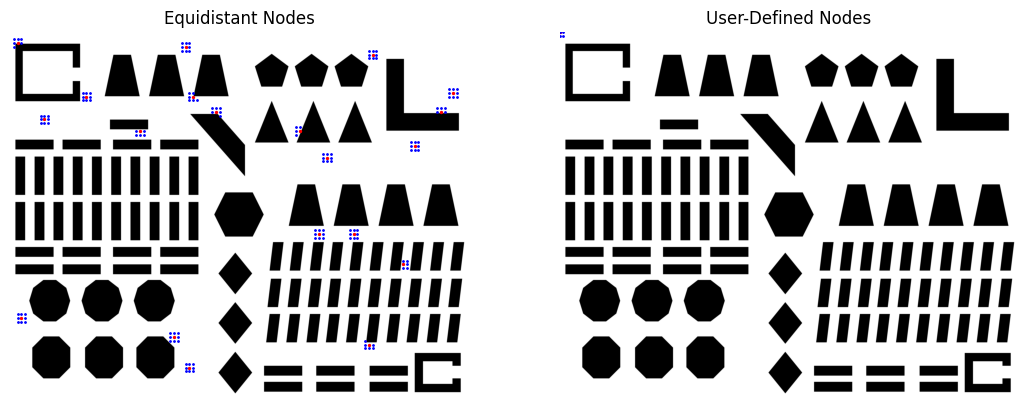

In [38]:

randomNodes = list(np.random.choice(allNodesVector[0], 20))

randomNodesNeighbours = []

for randomNode in randomNodes:
    randomNodesNeighbours = randomNodesNeighbours + list(randomNode.neighbours.keys())

XNodes = []
YNodes = []
for node in randomNodes:
    XNodes.append(node.coordinates[0])
    YNodes.append(node.coordinates[1])

XNeighbours = []
YNeighbours = []
for neighbour in randomNodesNeighbours:
    XNeighbours.append(neighbour.coordinates[0])
    YNeighbours.append(neighbour.coordinates[1])





userDefinedRandomNodes = userDefinedNodes.copy()
randomNodesNeighbours = []

for randomNode in userDefinedRandomNodes:
    randomNodesNeighbours = randomNodesNeighbours + list(randomNode.neighbours.keys())

XuserDefinedRandomNodesNodes = []
YuserDefinedRandomNodesNodes = []
for node in userDefinedRandomNodes:
    XuserDefinedRandomNodesNodes.append(node.coordinates[0])
    YuserDefinedRandomNodesNodes.append(node.coordinates[1])

XuserDefinedRandomNodesNeighbours = []
YuserDefinedRandomNodesNeighbours = []
for neighbour in randomNodesNeighbours:
    XuserDefinedRandomNodesNeighbours.append(neighbour.coordinates[0])
    YuserDefinedRandomNodesNeighbours.append(neighbour.coordinates[1])


plt.figure(figsize=(13, 11))
plt.subplot(1, 2, 1)
plt.scatter(XNodes, YNodes, c ='r', s=2)
plt.scatter(XNeighbours, YNeighbours, c ='b', s=1)
plt.title("Equidistant Nodes")
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')


plt.subplot(1, 2, 2)
plt.scatter(XuserDefinedRandomNodesNodes, YuserDefinedRandomNodesNodes, c ='r', s=2)
plt.scatter(XuserDefinedRandomNodesNeighbours, YuserDefinedRandomNodesNeighbours, c ='b', s=1) 
plt.title("User-Defined Nodes")
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(image)
plt.axis('off')
# plt.savefig('Neighbourhood Graph.png', dpi = 600, bbox_inches = 'tight')
plt.show()


# Improved A* Algorithm #

## `Non Post-Pruned Path vs Post-Pruned Path` ##

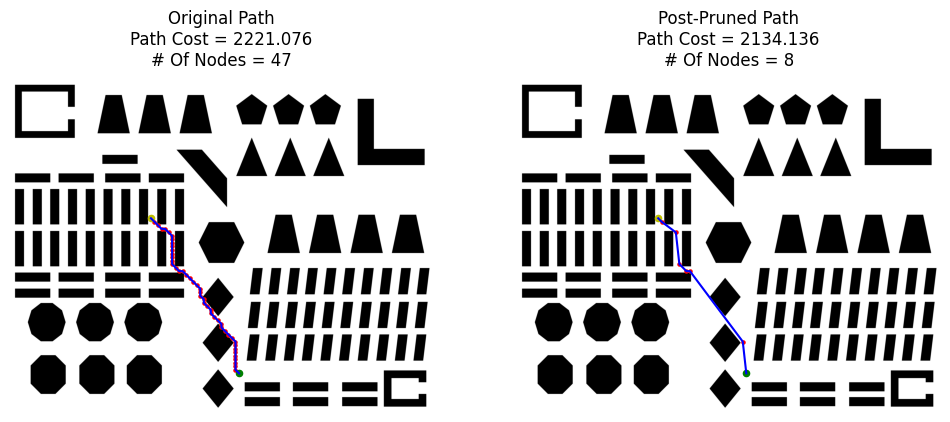

In [39]:
generatedPaths = {}

startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
goalNode = list(np.random.choice(allNodesVector[0], 2))[0]


path = AStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, False, spacing)[0]

pathCost = calculatePathCost(path)
[[X, Y],_] = getNodesCoordinatesFromNodesVector(path)


prunedPath = postPrunePath(path.copy(), cv2GrayImage)
prunedPathCost = calculatePathCost(prunedPath)
[[XPruned, YPruned],_] = getNodesCoordinatesFromNodesVector(path)

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.plot(XPruned, YPruned, c ='b')  
plt.scatter(XPruned, YPruned, c ='r', s=5) 
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20)  
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("Original Path\nPath Cost = {:.3f}\n# Of Nodes = {}".format(pathCost, len(path)))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout

[[XPruned, YPruned],_] = getNodesCoordinatesFromNodesVector(prunedPath)

plt.subplot(1, 2, 2)
plt.plot(XPruned, YPruned, c ='b') 
plt.scatter(XPruned, YPruned, c ='r', s=5)  
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20) 
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("Post-Pruned Path\nPath Cost = {:.3f}\n# Of Nodes = {}".format(prunedPathCost, len(prunedPath)))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout
# plt.savefig('Non Post-Pruned Path vs Post-Pruned Path.png', dpi = 600, bbox_inches = 'tight')
plt.show()

## `A*, Improved A*, Bidirectional A* and RRT*` ##

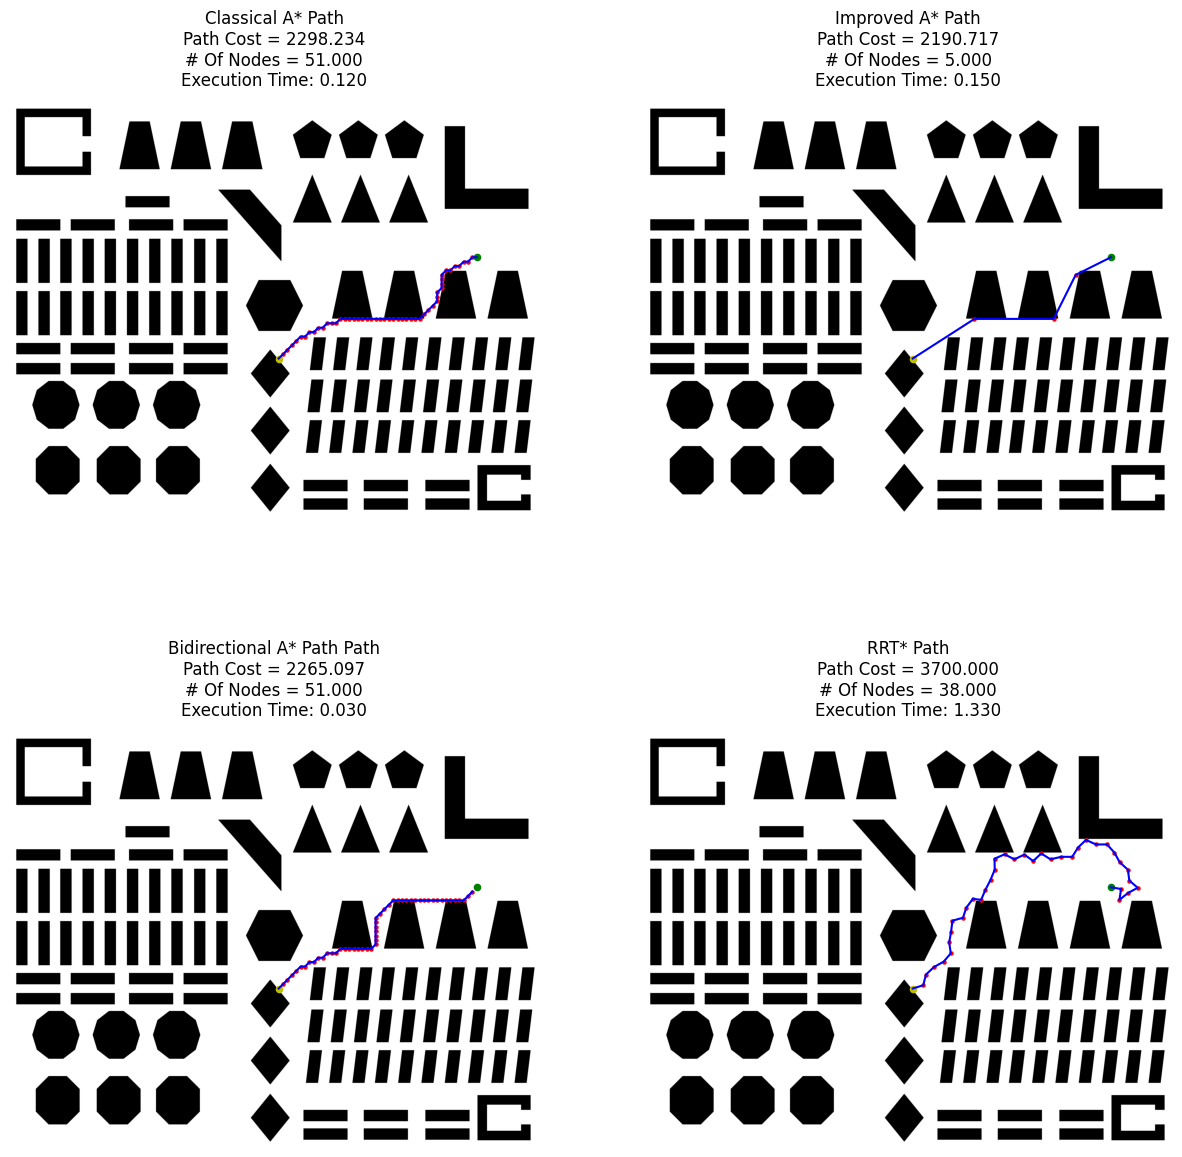

In [46]:
startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
goalNode = list(np.random.choice(allNodesVector[0], 2))[0]

classicalAstarStartTime = time.time()
pathAndCostClassicalAStar = AStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, False, spacing)
classicalAstarEndTime = time.time()


classicalAstarExecutionTime = classicalAstarEndTime - classicalAstarStartTime

AstarStartTime = time.time()
pathAndCostPrunedAStar = AStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, True, spacing)
AstarEndTime = time.time()

AstarExecutionTime = AstarEndTime - AstarStartTime

BiAstarStartTime = time.time()
pathAndCostBiAStar = BiAStarAlgorithm(startingNode, goalNode, generatedPaths, cv2GrayImage, False, spacing)
BiAstarEndTime = time.time()

BiAstarExecutionTime = BiAstarEndTime - BiAstarStartTime


RRTStarStartTime = time.time()
pathAndCostRRTStar = RRTStarAlgo(startingNode.coordinates, goalNode.coordinates, imageDirectory, 5000, 100, 100)
RRTstarEndTime = time.time()


RRTStarExecutionTime = RRTstarEndTime - RRTStarStartTime

#pathCostClassicalAstar = pathAndCostClassicalAStar[1]
pathCostClassicalAstar = calculatePathCost(pathAndCostClassicalAStar[0])
[[XClassicalAStar, YClassicalAStar],_] = getNodesCoordinatesFromNodesVector(pathAndCostClassicalAStar[0])

pathCostAstar = pathAndCostPrunedAStar[1]
[[XAStar, YAStar],_] = getNodesCoordinatesFromNodesVector(pathAndCostPrunedAStar[0])

#pathCostBiAStar = pathAndCostBiAStar[1]
pathCostBiAStar = calculatePathCost(pathAndCostBiAStar[0])
[[XBiAStar, YBiAStar],_] = getNodesCoordinatesFromNodesVector(pathAndCostBiAStar[0])

pathCostRRTStar = pathAndCostRRTStar[1]
XRRTStar = []
YRRTStar = []

for c in range(len(pathAndCostRRTStar[0])):
    XRRTStar.append(pathAndCostRRTStar[0][c][0])
    YRRTStar.append(pathAndCostRRTStar[0][c][1])

fig = plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
plt.plot(XClassicalAStar, YClassicalAStar, c ='b')  
plt.scatter(XClassicalAStar, YClassicalAStar, c ='r', s=5) 
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20)  
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("Classical A* Path\nPath Cost = {:.3f}\n# Of Nodes = {:.3f}\nExecution Time: {:.3f}".format(pathCostClassicalAstar, len(pathAndCostClassicalAStar[0]), classicalAstarExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout


plt.subplot(2, 2, 2)
plt.plot(XAStar, YAStar, c ='b')  
plt.scatter(XAStar, YAStar, c ='r', s=5) 
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20)  
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("Improved A* Path\nPath Cost = {:.3f}\n# Of Nodes = {:.3f}\nExecution Time: {:.3f}".format(pathCostAstar, len(pathAndCostPrunedAStar[0]), AstarExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout


plt.subplot(2, 2, 3)
plt.plot(XBiAStar, YBiAStar, c ='b') 
plt.scatter(XBiAStar, YBiAStar, c ='r', s=5)  
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20) 
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("Bidirectional A* Path Path\nPath Cost = {:.3f}\n# Of Nodes = {:.3f}\nExecution Time: {:.3f}".format(pathCostBiAStar, len(pathAndCostBiAStar[0]), BiAstarExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout


plt.subplot(2, 2, 4)
plt.plot(XRRTStar, YRRTStar, c ='b') 
plt.scatter(XRRTStar, YRRTStar, c ='r', s=5)  
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=20) 
plt.scatter(goalNode.coordinates[0], goalNode.coordinates[1], c ='g', s=20)  
plt.title("RRT* Path\nPath Cost = {:.3f}\n# Of Nodes = {:.3f}\nExecution Time: {:.3f}".format(pathCostRRTStar, len(pathAndCostRRTStar[0]), RRTStarExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout
plt.savefig('AStar, Improved AStar, Bidirectional AStar and RRTStar.png', dpi = 600, bbox_inches = 'tight')
plt.show()

# Ordering Module #

In [41]:
startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
absoluteStartingNode = startingNode
goalNodesNumber = 5
goalNodes = list(np.random.choice(allNodesVector[0], goalNodesNumber))
goalNodesAndStartingNode = goalNodes.copy()
goalNodesAndStartingNode.append(startingNode)
goalNodesAndStartingNodeCentroidCoordinates = getGoalNodesCentroidCoordinates(goalNodesAndStartingNode)
[[XGoal, YGoal],_] = getNodesCoordinatesFromNodesVector(goalNodes)


print("The starting node coordinates are: ", startingNode.coordinates)
print("The coordinates of the goal nodes are:", getNodesCoordinatesTuplesFromNodesVector(goalNodes))

The starting node coordinates are:  [1040  440]
The coordinates of the goal nodes are: [[3600, 40], [1840, 3520], [4560, 1160], [3600, 3400], [1200, 3360]]


## `Sequential Angle-Based Vs. Combined Angle-Based Ordering` ##

Combined time taken for getCombinedAngleBasedOrderedGoalNodes and generateTotalPath: 5.340069055557251 seconds


C:\Users\abdul\AppData\Local\Temp\ipykernel_19144\2864688296.py:679: RuntimeWarning: invalid value encountered in scalar divide
  angleRad = np.arccos(np.dot(startingCurrentVector, startGoalVector)/(np.linalg.norm(startingCurrentVector)*np.linalg.norm(startGoalVector)))


Combined time taken for getSequentialAngleBasedOrderedGoalNodes and generateTotalPath: 5.340069055557251 seconds


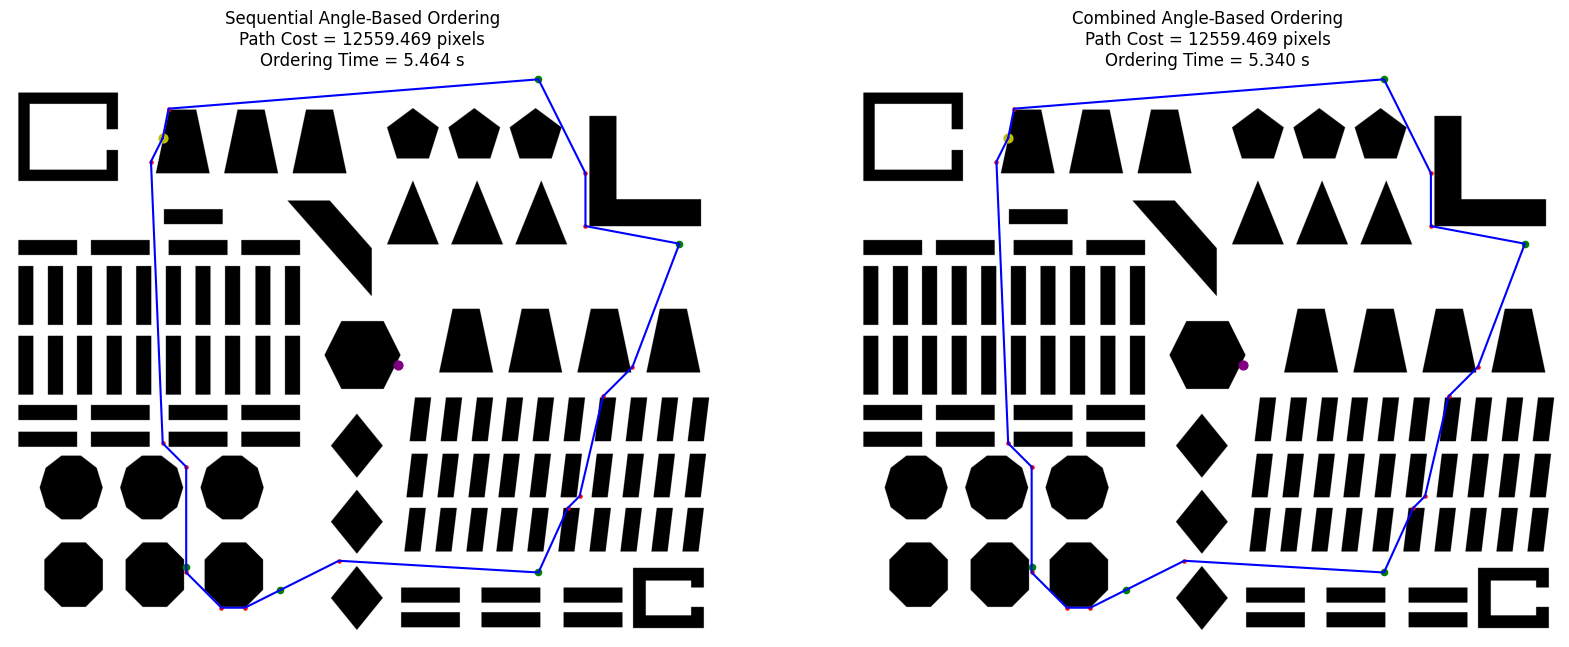

In [42]:


combinedAngleBasedOrderedGoalNodesStartTime = time.time()
combinedAngleBasedOrderedGoalNodes = getCombinedAngleBasedOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, goalNodesAndStartingNodeCentroidCoordinates, cv2GrayImage, True)
totalPathAndCostOfCombinedAngleBasedOrderedGoalNodes = generateTotalPath(startingNode, combinedAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
combinedAngleBasedOrderedGoalNodesEndTime = time.time()
combinedAngleBasedOrderedGoalNodesExecutionTime = combinedAngleBasedOrderedGoalNodesEndTime - combinedAngleBasedOrderedGoalNodesStartTime
print(f"Combined time taken for getCombinedAngleBasedOrderedGoalNodes and generateTotalPath: {combinedAngleBasedOrderedGoalNodesExecutionTime} seconds")


sequentialAngleBasedOrderedGoalNodesStartTime = time.time()
sequentialAngleBasedOrderedGoalNodes = getSequentialAngleBasedOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, goalNodesAndStartingNodeCentroidCoordinates, cv2GrayImage, True)
totalPathAndCostOfSequentialAngleBasedOrderedGoalNodes = generateTotalPath(startingNode, sequentialAngleBasedOrderedGoalNodes, generatedPaths, cv2GrayImage)
sequentialAngleBasedOrderedGoalNodesEndTime = time.time()
sequentialAngleBasedOrderedGoalNodesExecutionTime = sequentialAngleBasedOrderedGoalNodesEndTime - sequentialAngleBasedOrderedGoalNodesStartTime
print(f"Combined time taken for getSequentialAngleBasedOrderedGoalNodes and generateTotalPath: {combinedAngleBasedOrderedGoalNodesExecutionTime} seconds")


[[XcombinedAngleBasedOrderedGoalNodes, YcombinedAngleBasedOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfCombinedAngleBasedOrderedGoalNodes[0])
[[XsequentialAngleBasedOrderedGoalNodes, YsequentialAngleBasedOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfSequentialAngleBasedOrderedGoalNodes[0])


plt.figure(figsize=(20,15))

plt.subplot(1, 2, 1)
plt.plot(XsequentialAngleBasedOrderedGoalNodes, YsequentialAngleBasedOrderedGoalNodes, c ='b')
plt.scatter(XsequentialAngleBasedOrderedGoalNodes, YsequentialAngleBasedOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Sequential Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostOfSequentialAngleBasedOrderedGoalNodes[1], sequentialAngleBasedOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout



plt.subplot(1, 2, 2)
plt.plot(XcombinedAngleBasedOrderedGoalNodes, YcombinedAngleBasedOrderedGoalNodes, c ='b')
plt.scatter(XcombinedAngleBasedOrderedGoalNodes, YcombinedAngleBasedOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Combined Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostOfCombinedAngleBasedOrderedGoalNodes[1], combinedAngleBasedOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
# plt.savefig('Sequential Angle-Based Vs. Combined Angle-Based Ordering.png', dpi = 600, bbox_inches = 'tight')
plt.tight_layout

plt.show()


## `Ensemble Angle-Based Ordering vs. Post-Pruned Ensemble Angle-Based Ordering` ##

C:\Users\abdul\AppData\Local\Temp\ipykernel_19144\2864688296.py:679: RuntimeWarning: invalid value encountered in scalar divide
  angleRad = np.arccos(np.dot(startingCurrentVector, startGoalVector)/(np.linalg.norm(startingCurrentVector)*np.linalg.norm(startGoalVector)))


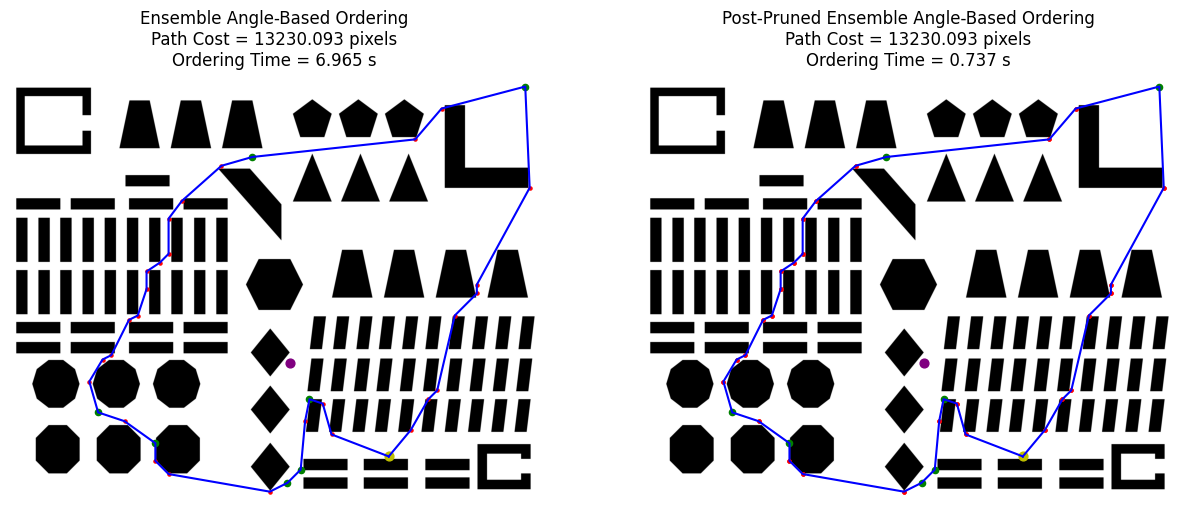

In [43]:
startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
absoluteStartingNode = startingNode
goalNodesNumber = 7
goalNodes = list(np.random.choice(allNodesVector[0], goalNodesNumber))
goalNodesAndStartingNode = goalNodes.copy()
goalNodesAndStartingNode.append(startingNode)
goalNodesAndStartingNodeCentroidCoordinates = getGoalNodesCentroidCoordinates(goalNodesAndStartingNode)
[[XGoal, YGoal],_] = getNodesCoordinatesFromNodesVector(goalNodes)



ensembleAngleOrderedGoalNodesStartTime = time.time()
ensembleAngleOrderedGoalNodes = getAngleBasedEnsembleOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, goalNodesAndStartingNodeCentroidCoordinates, cv2GrayImage)[0]
totalPathAndCostOfensembleAngle = [ensembleAngleOrderedGoalNodes[1], ensembleAngleOrderedGoalNodes[2]]
ensembleAngleOrderedGoalNodesEndTime = time.time()
ensembleAngleOrderedGoalNodesExecutionTime = ensembleAngleOrderedGoalNodesEndTime - ensembleAngleOrderedGoalNodesStartTime




postPrunedOrderedGoalNodesStartTime = time.time()
# postPrunedOrderedGoalNodes = two_opt_algorithm_with_Astar(startingNode, ensembleAngleOrderedGoalNodes[0].copy(), generatedPaths, cv2GrayImage)
postPrunedOrderedGoalNodes = modifiedTwoOptPostPruning(ensembleAngleOrderedGoalNodes[1].copy(), cv2GrayImage)
totalPathAndCostpostPruned = generateTotalPath(absoluteStartingNode, postPrunedOrderedGoalNodes, generatedPaths, cv2GrayImage)
postPrunedOrderedGoalNodesEndTime = time.time()
postPrunedOrderedGoalNodesExecutionTime = postPrunedOrderedGoalNodesEndTime - postPrunedOrderedGoalNodesStartTime



[[XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfensembleAngle[0])
[[XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostpostPruned[0])


plt.figure(figsize=(15,10))






plt.subplot(1, 2, 1)
plt.plot(XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes, c ='b')
plt.scatter(XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Ensemble Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostOfensembleAngle[1], ensembleAngleOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout

plt.subplot(1, 2, 2)
plt.plot(XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes, c ='b')
plt.scatter(XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Post-Pruned Ensemble Angle-Based Ordering\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostpostPruned[1], postPrunedOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.tight_layout
plt.imshow(image)
# plt.savefig('temp\ Ensemble Angle-Based Ordering vs. Post-Pruned Ensemble Angle-Based Ordering.png', dpi = 600, bbox_inches = 'tight')


## `Optimal Ordering Using Google's TSP Solver` ##

Objective: 6858 miles
Route for vehicle 0:
 0 -> 1 -> 3 -> 4 -> 2 -> 5 -> 0



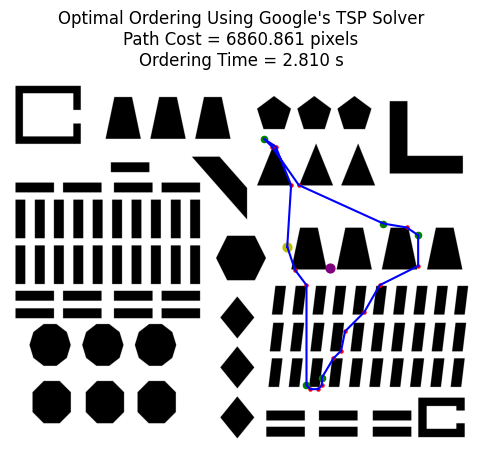

In [44]:
startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
absoluteStartingNode = startingNode
goalNodesNumber = 5
goalNodes = list(np.random.choice(allNodesVector[0], goalNodesNumber))
goalNodesAndStartingNode = goalNodes.copy()
goalNodesAndStartingNode.append(startingNode)
goalNodesAndStartingNodeCentroidCoordinates = getGoalNodesCentroidCoordinates(goalNodesAndStartingNode)

[[XGoal, YGoal],_] = getNodesCoordinatesFromNodesVector(goalNodes)


TSPSolverOrderStartTime = time.time()
totalPathAndCostTSPSolver = getTSPSolverBasedOrder(startingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
TSPSolverOrderEndTime = time.time()
TSPSolverOrderExecutionTime = TSPSolverOrderEndTime - TSPSolverOrderStartTime

[[XTSPSolverOrderedGoalNodes, YTSPSolverOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostTSPSolver[0])

plt.plot(XTSPSolverOrderedGoalNodes, YTSPSolverOrderedGoalNodes, c ='b')
plt.scatter(XTSPSolverOrderedGoalNodes, YTSPSolverOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Optimal Ordering Using Google\'s TSP Solver\nPath Cost = {:.3f} pixels\nOrdering Time = {:.3f} s".format(totalPathAndCostTSPSolver[1], TSPSolverOrderExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.tight_layout
plt.imshow(image)
#plt.savefig('temp\ Optimal Ordering Using Google\'s TSP Solver.png', dpi = 600, bbox_inches = 'tight')

## `Ordering Algorithm Comparisons` ##

Objective: 11785 miles
Route for vehicle 0:
 0 -> 1 -> 3 -> 2 -> 4 -> 5 -> 0



C:\Users\abdul\AppData\Local\Temp\ipykernel_19144\2864688296.py:679: RuntimeWarning: invalid value encountered in scalar divide
  angleRad = np.arccos(np.dot(startingCurrentVector, startGoalVector)/(np.linalg.norm(startingCurrentVector)*np.linalg.norm(startGoalVector)))


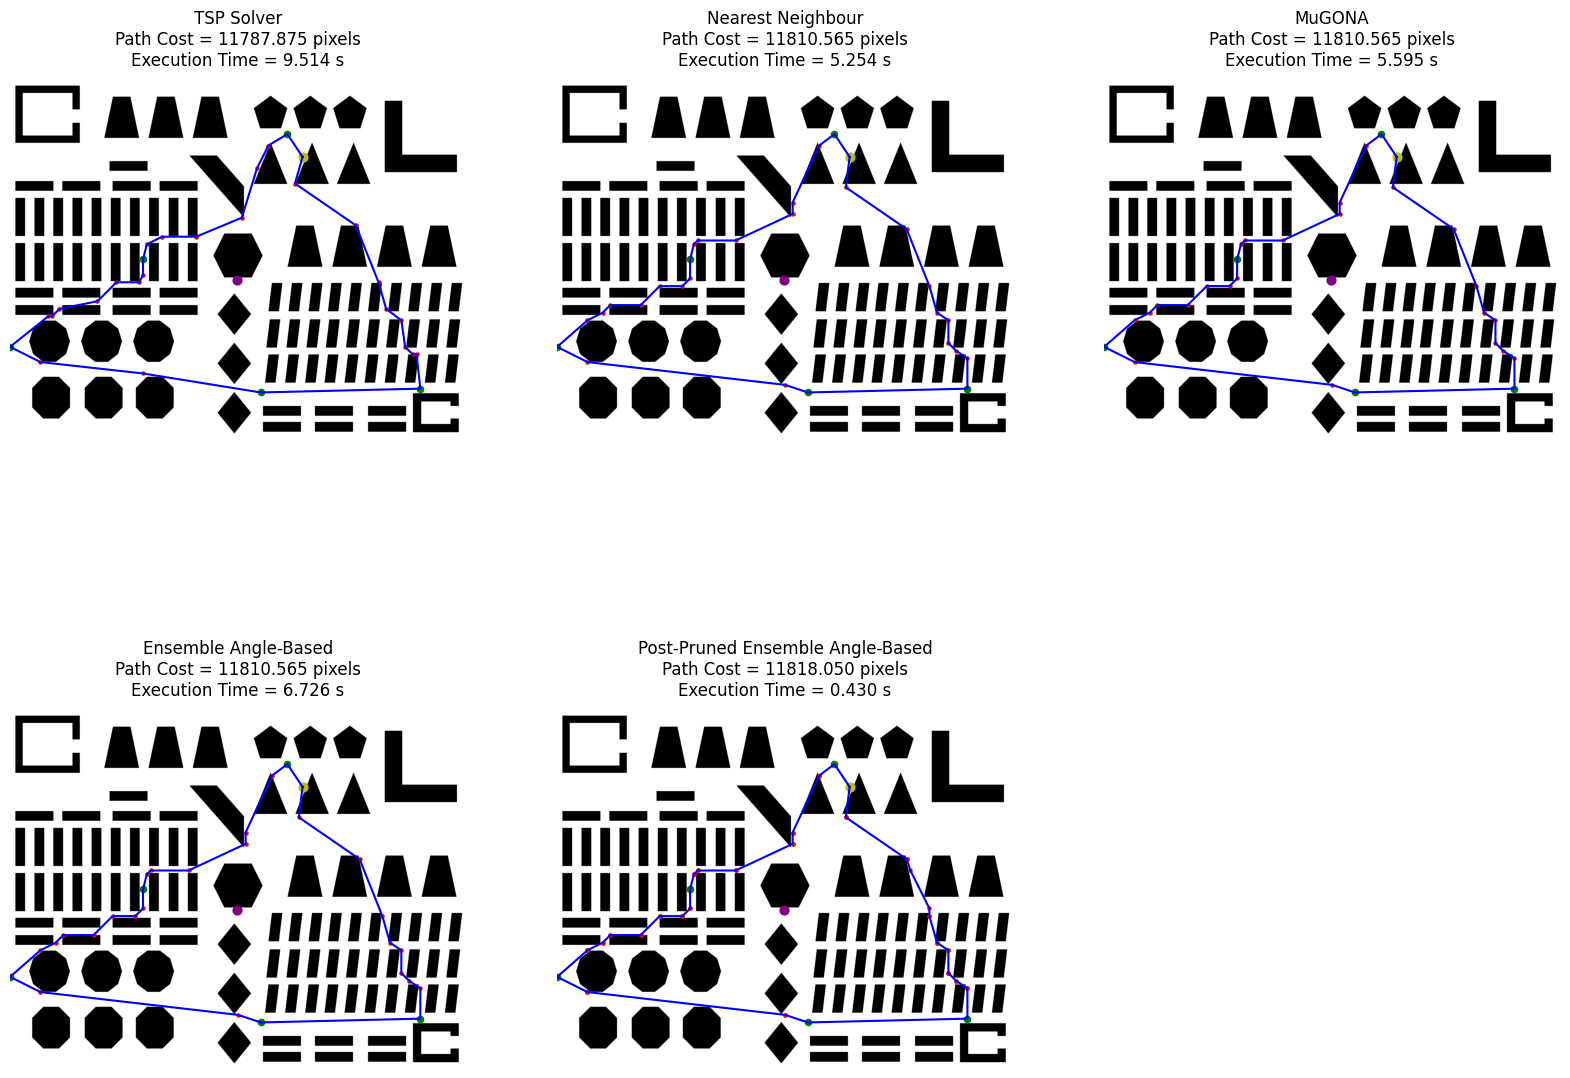

In [45]:
startingNode = list(np.random.choice(allNodesVector[0], 2))[0]
absoluteStartingNode = startingNode
goalNodesNumber = 5
goalNodes = list(np.random.choice(allNodesVector[0], goalNodesNumber))
goalNodesAndStartingNode = goalNodes.copy()
goalNodesAndStartingNode.append(startingNode)
goalNodesAndStartingNodeCentroidCoordinates = getGoalNodesCentroidCoordinates(goalNodesAndStartingNode)
[[XGoal, YGoal],_] = getNodesCoordinatesFromNodesVector(goalNodes)


TSPSolverOrderedGoalNodesStartTime = time.time()
TSPSolverOrderedGoalNodes = getTSPSolverBasedOrder(startingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
totalPathAndCostTSPSolver = [TSPSolverOrderedGoalNodes[0], TSPSolverOrderedGoalNodes[1]]
TSPSolverOrderedGoalNodesEndTime = time.time()
TSPSolverOrderedGoalNodesExecutionTime = TSPSolverOrderedGoalNodesEndTime - TSPSolverOrderedGoalNodesStartTime

nearestNeighbourOrderedGoalNodesStartTime = time.time()
nearestNeighbourOrderedGoalNodes = getNearestOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
totalPathAndCostOfnearestNeighbourOrderedGoalNodes = generateTotalPath(startingNode, nearestNeighbourOrderedGoalNodes, generatedPaths, cv2GrayImage)
nearestNeighbourOrderedGoalNodesEndTime = time.time()
nearestNeighbourOrderedGoalNodesExecutionTime = nearestNeighbourOrderedGoalNodesEndTime - nearestNeighbourOrderedGoalNodesStartTime


MuGONAOrderedGoalNodesStartTime = time.time()
MuGONAOrderedGoalNodes = getMuGONAOrderedGoalNodes(absoluteStartingNode, goalNodes.copy(), generatedPaths, cv2GrayImage)
totalPathAndCostMuGONA = generateTotalPath(absoluteStartingNode, MuGONAOrderedGoalNodes, generatedPaths, cv2GrayImage)
MuGONAOrderedGoalNodesEndTime = time.time()
MuGONAOrderedGoalNodesExecutionTime = MuGONAOrderedGoalNodesEndTime - MuGONAOrderedGoalNodesStartTime


ensembleAngleOrderedGoalNodesStartTime = time.time()
ensembleAngleOrderedGoalNodes = getAngleBasedEnsembleOrderedGoalNodes(startingNode, goalNodes.copy(), generatedPaths, goalNodesAndStartingNodeCentroidCoordinates, cv2GrayImage)[0]
totalPathAndCostOfensembleAngle = [ensembleAngleOrderedGoalNodes[1], ensembleAngleOrderedGoalNodes[2]]
ensembleAngleOrderedGoalNodesEndTime = time.time()
ensembleAngleOrderedGoalNodesExecutionTime = ensembleAngleOrderedGoalNodesEndTime - ensembleAngleOrderedGoalNodesStartTime




postPrunedOrderedGoalNodesStartTime = time.time()

postPrunedOrderedGoalNodes = modifiedTwoOptPostPruning(ensembleAngleOrderedGoalNodes[1].copy(), cv2GrayImage)
totalPathAndCostpostPruned = generateTotalPath(absoluteStartingNode, postPrunedOrderedGoalNodes, generatedPaths, cv2GrayImage)
postPrunedOrderedGoalNodesEndTime = time.time()
postPrunedOrderedGoalNodesExecutionTime = postPrunedOrderedGoalNodesEndTime - postPrunedOrderedGoalNodesStartTime


[[XTSPSolverOrderedGoalNodes, YTSPSolverOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostTSPSolver[0])
[[XnearestNeighbourOrdered, YnearestNeighbourOrdered],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfnearestNeighbourOrderedGoalNodes[0])
[[XMuGONAOrderedGoalNodes, YMuGONAOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostMuGONA[0])
[[XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostOfensembleAngle[0])
[[XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes],_] = getNodesCoordinatesFromNodesVector(totalPathAndCostpostPruned[0])


plt.figure(figsize=(20,15))





plt.subplot(2, 3, 1)
plt.plot(XTSPSolverOrderedGoalNodes, YTSPSolverOrderedGoalNodes, c ='b')
plt.scatter(XTSPSolverOrderedGoalNodes, YTSPSolverOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("TSP Solver\nPath Cost = {:.3f} pixels\nExecution Time = {:.3f} s".format(totalPathAndCostTSPSolver[1], TSPSolverOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout


plt.subplot(2, 3, 2)
plt.plot(XnearestNeighbourOrdered, YnearestNeighbourOrdered, c ='b')
plt.scatter(XnearestNeighbourOrdered, YnearestNeighbourOrdered, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Nearest Neighbour\nPath Cost = {:.3f} pixels\nExecution Time = {:.3f} s".format(totalPathAndCostOfnearestNeighbourOrderedGoalNodes[1], nearestNeighbourOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout



plt.subplot(2, 3, 3)
plt.plot(XMuGONAOrderedGoalNodes, YMuGONAOrderedGoalNodes, c ='b')
plt.scatter(XMuGONAOrderedGoalNodes, YMuGONAOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("MuGONA\nPath Cost = {:.3f} pixels\nExecution Time = {:.3f} s".format(totalPathAndCostMuGONA[1], MuGONAOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout


plt.subplot(2, 3, 4)
plt.plot(XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes, c ='b')
plt.scatter(XensembleAngleOrderedGoalNodes, YensembleAngleOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Ensemble Angle-Based\nPath Cost = {:.3f} pixels\nExecution Time = {:.3f} s".format(totalPathAndCostOfensembleAngle[1], ensembleAngleOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout




plt.subplot(2, 3, 5)
plt.plot(XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes, c ='b')
plt.scatter(XpostPrunedOrderedGoalNodes, YpostPrunedOrderedGoalNodes, c ='r', s=5)
plt.scatter(XGoal, YGoal, c = 'g', s = 20)
plt.scatter(startingNode.coordinates[0], startingNode.coordinates[1], c ='y', s=40)
plt.scatter(goalNodesAndStartingNodeCentroidCoordinates[0], goalNodesAndStartingNodeCentroidCoordinates[1], c = 'purple', s = 40 )
plt.title("Post-Pruned Ensemble Angle-Based\nPath Cost = {:.3f} pixels\nExecution Time = {:.3f} s".format(totalPathAndCostpostPruned[1], postPrunedOrderedGoalNodesExecutionTime))
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.imshow(image)
plt.tight_layout
# plt.savefig('Ordering Algorithms Comparisons.png', dpi = 600, bbox_inches = 'tight')
plt.show()